In [1]:
from pkasolver import data
from pkasolver import chem
from pkasolver import ml
from pkasolver import stat
from pkasolver import constants as c

import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#Model package imports
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch.nn import Sequential as Seq, Linear as Lin, ReLU
from torch_geometric.nn import GCNConv
from torch_geometric.nn import NNConv
from torch_geometric.nn import global_max_pool
from torch import optim

from captum.attr import IntegratedGradients

In [2]:
#SDFs to dict of preprocessed DataFrames
path = "../data/Baltruschat/"
sdf_training = "combined_training_datasets_unique.sdf"
sdf_novartis = "novartis_cleaned_mono_unique_notraindata.sdf"
sdf_AvLiLuMoVe = "AvLiLuMoVe_cleaned_mono_unique_notraindata.sdf"

datasets = {
    "Training": path+sdf_training,
    "Novartis": path+sdf_novartis,
    "AvLiLuMoVe": path+sdf_AvLiLuMoVe,
}

pd_datasets = data.preprocess_all(datasets, title='pd_all_datasets')
with open(f'data/pd_all_datasets.pkl', 'wb') as pickle_file:
        pickle.dump(pd_datasets,pickle_file)

In [3]:
#Hyperparameters
node_features = [
    'atomic_number',
    'formal_charge',
    'chiral_tag',
    'hybridization',
    'explicit_Hs_number',
    'aromatic_tag',
    'total_valence',
    'total_degree'
]

edge_features = [
#     'bond_type',
#     'is_conjugated'
]

train_test_split = 0.8
batch_size = 64
learning_rate=0.001
num_epochs = 40000
device="cpu"
checkpoint_path = 'modelsaves/1#/'
paired_model = False

In [5]:
# Load dict of DataFrames
with open('data/pd_all_datasets.pkl', 'rb') as pickle_file:
    pd_dataset = pickle.load(pickle_file)

# make pyG Dataset form 'Training'- Dataset    
dataset = data.make_pyg_dataset(pd_dataset['Training'], node_features, edge_features, paired=paired_model)
# print(dataset[0], '\n\n' ,dataset[0].x,'\n\n', dataset[0].edge_index, dataset[0].y,dataset[0].edge_attr)
# Split dataset
train_data, test_data = ml.pyg_split(dataset, train_test_split, shuffle=True)
# Make loaders
train_loader = ml.dataset_to_dataloader(train_data, batch_size, shuffle=True)
test_loader = ml.dataset_to_dataloader(test_data, batch_size)


In [6]:
def pyg_crossval_split(dataset,num_crossval=5, shuffle=False):
    """Take List of PyG Data oojcts and a split ratio between 0 and 1 
    and return a list of Training data and a list of test data.
    """
    if shuffle:
        random.shuffle(dataset)
    
    split_length=int(len(dataset)/num_crossval)
    data_list = []
    for i in range(num_crossval):
        print(split_length*(i+1))
        data_list.append(dataset[split_length*i:split_length*(i+1)])
    return data_list

In [7]:
#Load Testsets:
pd_dataset['Novartis'].head(2)

# make pyG Dataset form 'Training'- Dataset    
dataset_nov = data.make_pyg_dataset(pd_dataset['Novartis'], node_features, edge_features, paired=paired_model)
# print(dataset_nov[0].ID,dataset_nov[0], '\n\n' ,dataset_nov[0].x,'\n\n', dataset_nov[0].edge_index, dataset_nov[0].y)
nov_loader = ml.dataset_to_dataloader(dataset_nov, batch_size)

dataset_avli = data.make_pyg_dataset(pd_dataset['AvLiLuMoVe'], node_features, edge_features, paired=paired_model)
# print(dataset_avli[0].ID,dataset_avli[0], '\n\n' ,dataset_avli[0].x,'\n\n', dataset_avli[0].edge_index, dataset_avli[0].y)
avli_loader = ml.dataset_to_dataloader(dataset_avli, batch_size)

In [8]:
parameter_dict={
    'paired':paired_model,
    'num_graph_layers':4,
    'hidden_channels':96,
    'num_linear_layers':1,
    'edge_nn_layer':None,
    'num_node_features':dataset[0].num_features,
    'num_edge_features':dataset[0].num_edge_features
    
}

## Model with Single Data

In [9]:
from torch.nn import ModuleList

#Model Class:

def convs(parameter_dict):
    num_graph_layers = parameter_dict['num_graph_layers']
    num_linear_layers = parameter_dict['num_linear_layers']
    num_node_features = parameter_dict['num_node_features']
    num_edge_features = parameter_dict['num_edge_features']
    hidden_channels=parameter_dict['hidden_channels']
    paired = parameter_dict['paired']
    
    if num_edge_features > 0:
        nn = Seq(Lin(num_edge_features, 16), ReLU(), Lin(16, num_node_features*hidden_channels))
        nn1 = Seq(Lin(num_edge_features, 16), ReLU(), Lin(16, hidden_channels* hidden_channels))
        convs = ModuleList([NNConv(num_node_features, hidden_channels, nn=nn)])
        convs.extend([NNConv(hidden_channels, hidden_channels, nn=nn1) for i in range(num_graph_layers-1)])
    else:
        convs = ModuleList([GCNConv(num_node_features, hidden_channels)])
        convs.extend([GCNConv(hidden_channels, hidden_channels) for i in range(num_graph_layers-1)])
    return convs

def lins(parameter_dict):
    num_graph_layers = parameter_dict['num_graph_layers']
    num_linear_layers = parameter_dict['num_linear_layers']
    num_node_features = parameter_dict['num_node_features']
    num_edge_features = parameter_dict['num_edge_features']
    hidden_channels=parameter_dict['hidden_channels']
    paired = parameter_dict['paired']
    
    channels= hidden_channels
    if paired:
        channels= hidden_channels*2
    lins= ModuleList([Linear(channels, channels) for i in range(num_linear_layers-1)])
    lins.extend([Linear(channels, 1)])
    return lins


class GCN(torch.nn.Module):
    num_graph_layers = parameter_dict['num_graph_layers']
    num_linear_layers = parameter_dict['num_linear_layers']
    num_node_features = parameter_dict['num_node_features']
    num_edge_features = parameter_dict['num_edge_features']
    hidden_channels=parameter_dict['hidden_channels']
    paired = parameter_dict['paired']
    
    def __init__(self, parameter_dict):
        super(GCN, self).__init__()
        torch.manual_seed(1)
        
        num_graph_layers = parameter_dict['num_graph_layers']
        num_node_features = parameter_dict['num_node_features']
        num_edge_features = parameter_dict['num_edge_features']
        hidden_channels=parameter_dict['hidden_channels']
        paired = parameter_dict['paired']
        
        self.convs_x = convs(parameter_dict)
        if paired:
            self.convs_x2 = convs(parameter_dict)
        self.lin = lins(parameter_dict)


            
    def forward(self, data):
        try:
            if self.convs_x2:
                paired = True
        except:
            paired = False
            
        x = data.x
        if paired:
            x2 = data.x2
        # 1. Obtain node embeddings
        if len(edge_features) > 0:
            for i in range(len(self.convs_x)):
                x = self.convs_x[i](x, data.edge_index, data.edge_attr)
                x = x.relu()
            if paired:
                for i in range(len(self.convs_x2)):
                    x2 = self.convs_x2[i](x2, data.edge_index2, data.edge_attr2)
                    x2 = x2.relu()
                
        else:
            for i in range(len(self.convs_x)):
                x = self.convs_x[i](x, data.edge_index)
                x = x.relu()
            if paired:
                for i in range(len(self.convs_x2)):
                    x2 = self.convs_x2[i](x2, data.edge_index2)
                    x2 = x2.relu()

        # 2. Readout layer
        x = global_max_pool(x, data.x_batch.to(device=device))  # [batch_size, hidden_channels]
        if paired: 
            x2 = global_max_pool(x2, data.x2_batch.to(device=device))
            
        if paired:
            x = torch.cat((x, x2), 1)

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        for i in range(len(self.lin)):
                x = self.lin[i](x)
        return x

In [10]:
# Create Single model
model = GCN(parameter_dict).to(device=device)
print(model)

GCN(
  (convs_x): ModuleList(
    (0): GCNConv(8, 96)
    (1): GCNConv(96, 96)
    (2): GCNConv(96, 96)
    (3): GCNConv(96, 96)
  )
  (lin): ModuleList(
    (0): Linear(in_features=96, out_features=1, bias=True)
  )
)


In [11]:
#Single Model
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()
criterion_v = torch.nn.L1Loss() # that's the MAE Loss
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True)

def train(loader):
    model.train()
    for data in loader:  # Iterate in batches over the training dataset. 
        out = model(data)
        loss = criterion(out.flatten(), data.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad() # Clear gradients.
        
def test(loader):
    model.eval()
    loss = torch.Tensor([0]).to(device=device)
    for data in loader:  # Iterate in batches over the training dataset.
        out = model(data)  # Perform a single forward pass.
        loss += criterion_v(out.flatten(), data.y)
    return loss/len(loader) # MAE loss of batches can be summed and divided by the number of batches

In [12]:
# Save first checkpoint
checkpoint = {
    'epoch': 0,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'training_data': [train_data[i].ID for i in range(len(train_data))],
    'test_data': [test_data[i].ID for i in range(len(test_data))],
    'node_features': node_features,
    'edge_features': edge_features,
    'progress':'',
    'parameters':parameter_dict
}
    
torch.save(checkpoint,f'{checkpoint_path}checkpoint_epoch_0.pth.tar')

In [13]:
#load checkpoint 
checkpoint = torch.load('modelsaves/1#/checkpoint_epoch_0.pth.tar')
train_data =data.load_data(dataset, checkpoint['training_data'])
test_data =data.load_data(dataset, checkpoint['test_data'])
parameter_dict = checkpoint['parameters']

model = GCN(parameter_dict).to(device=device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
model.eval()

print(checkpoint['progress'])

In [14]:
for epoch in range(checkpoint['epoch'], num_epochs):
    if epoch != 0: 
        train(train_loader)
    if epoch % 2 == 0:
        train_acc = test(train_loader)
        test_acc = test(test_loader)
        update = f'Epoch: {epoch:03d}, Train MAE: {train_acc.item():.4f}, Test MAE: {test_acc.item():.4f}'
        print(update)
    if epoch % 40 ==0:
        checkpoint = ml.update_checkpoint(checkpoint, epoch, optimizer, update, model)
        print('Saving checkpoint...')
        torch.save(checkpoint,f'{checkpoint_path}checkpoint_epoch_{epoch}.pth.tar')
        print('done')

Epoch: 000, Train MAE: 7.1538, Test MAE: 7.2858
Saving checkpoint...
done
Epoch: 002, Train MAE: 1.9661, Test MAE: 1.9509
Epoch: 004, Train MAE: 1.8802, Test MAE: 1.8532
Epoch: 006, Train MAE: 1.8555, Test MAE: 1.8390
Epoch: 008, Train MAE: 1.8470, Test MAE: 1.8325
Epoch: 010, Train MAE: 1.8360, Test MAE: 1.8221
Epoch: 012, Train MAE: 1.8191, Test MAE: 1.8079
Epoch: 014, Train MAE: 1.8015, Test MAE: 1.7809
Epoch: 016, Train MAE: 1.8456, Test MAE: 1.8335
Epoch: 018, Train MAE: 1.7462, Test MAE: 1.7333
Epoch: 020, Train MAE: 1.7435, Test MAE: 1.7311
Epoch: 022, Train MAE: 1.7075, Test MAE: 1.6889
Epoch: 024, Train MAE: 1.6757, Test MAE: 1.6645
Epoch: 026, Train MAE: 1.6654, Test MAE: 1.6561
Epoch: 028, Train MAE: 1.6900, Test MAE: 1.6941
Epoch: 030, Train MAE: 1.6428, Test MAE: 1.6390
Epoch: 032, Train MAE: 1.6079, Test MAE: 1.6084
Epoch: 034, Train MAE: 1.5512, Test MAE: 1.5613
Epoch: 036, Train MAE: 1.5219, Test MAE: 1.5344
Epoch: 038, Train MAE: 1.4468, Test MAE: 1.4735
Epoch: 040, Tr

KeyboardInterrupt: 

In [27]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from scipy import stats
import numpy as np
import pandas as pd

def test_GCN(loader, dataset_name):
    model.eval()
    i = 0
    for data in loader:  # Iterate in batches over the training dataset.
        y_pred = model(data).reshape(-1)
        y_true = data.y
        if i == 0:
            Y_pred = y_pred 
            Y_true = y_true
        else:
            Y_true=torch.hstack((Y_true,y_true))
            Y_pred=torch.hstack((Y_pred,y_pred))
        i+=1
    return pd.DataFrame({'Dataset':dataset_name,'pKa_experimental':Y_true.detach().numpy(), 'pKa_predicted':Y_pred.detach().numpy()})

def f(x):
    d = {}
    d['r2_score'] = r2_score(x['pKa_experimental'],x['pKa_predicted'])
    d['MAE'] = mean_absolute_error(x['pKa_experimental'],x['pKa_predicted'])
    d['RMSE'] = np.sqrt(mean_squared_error(x['pKa_experimental'],x['pKa_predicted']))
    return pd.Series(d, index=['r2_score', 'MAE', 'RMSE']).round(3)

In [28]:
df=pd.concat([test_GCN(test_loader,'Validation_set'),
         test_GCN(nov_loader,'Novartis_set'),
         test_GCN(avli_loader,'Literature_set')])

df.groupby('Dataset').apply(f)

,r2_score,MAE,RMSE
Dataset,,,
Literature_set,0.790,0.835,1.080
Novartis_set,0.416,1.430,1.760
Validation_set,0.590,1.218,1.544


In [29]:
import random
import torch
from captum.attr import IntegratedGradients
from captum.attr import LayerConductance
from captum.attr import NeuronConductance
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.linalg import block_diag
#####


In [35]:
def calc_importances(ig, dataset, sample_size, node_feature_names, edge_feature_names=None, device='cpu'):
    """Take Integrated Gradients Object, PyG Dataset and desired sample size. 
    Return two np.arrays of importances of nodes and edges, respectivly.
    """
    if edge_feature_names == None:
        edge_feature_names=[]    
    feature_names= node_feature_names + edge_feature_names 
    attr = np.empty((0,len(feature_names)))
    ids = []
    
    i = 0
    for input_data in random.sample(dataset, sample_size):
        ids.extend([input_data.ID]*(input_data.x.shape[0]+input_data.edge_index.shape[1]))
        if edge_feature_names==[]:
#             _attr, _delta = ig.attribute((input_data.x),
#                                          additional_forward_args=(input_data.edge_attr, input_data.edge_index, torch.zeros(input_data.x.shape[0], dtype=int).to(device=device)), 
#                                          internal_batch_size=input_data.x.shape[0], 
#                                          return_convergence_delta=True)
            _attr, _delta = ig.attribute((input_data),
                                         additional_forward_args=(input_data.edge_attr, input_data.edge_index, torch.zeros(input_data.x.shape[0], dtype=int).to(device=device)), 
                                         internal_batch_size=input_data.x.shape[0], 
                                         return_convergence_delta=True)
            attr_row = _attr.detach().numpy()
        else:
            _attr, _delta = ig.attribute((input_data.x, input_data.edge_attr),
                                         additional_forward_args=(input_data.edge_index, torch.zeros(input_data.x.shape[0], dtype=int).to(device=device)), 
                                         internal_batch_size=input_data.x.shape[0], 
                                         return_convergence_delta=True)

            attr_row = block_diag(_attr[0].detach().numpy(), _attr[1].detach().numpy())
#             print(attr_row)
        attr = np.vstack((attr, attr_row))
        
        if i%5==0:
            print(f'{i+1} of {sample_size}')
        i += 1
    
    df =pd.DataFrame(attr,columns=feature_names)
    df.insert(0, 'ID', ids)
    return df

In [36]:
ig = IntegratedGradients(model)
attr_df = calc_importances(ig, dataset, 100, node_features, edge_features)

AssertionError: `inputs` must have type torch.Tensor but <class 'torch_geometric.data.data.Data'> found: 

In [33]:
attr_df

NameError: name 'attr_df' is not defined

NameError: name 'attr_df' is not defined

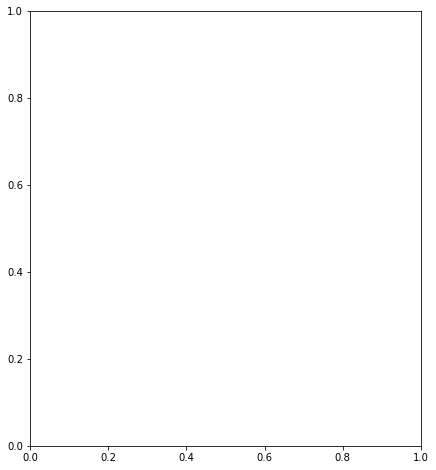

In [34]:
## sns.set_context('talk')
f, ax = plt.subplots(figsize=(7, 8))
sns.violinplot(y="variable", x="value", data=pd.melt(attr_df.drop(['ID'], axis=1)),inner="points", scale='count')
ax.set(xlabel='Feature attributions', ylabel='')
plt.show()